In [119]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

In [43]:
picture_size = 48
folder_path = '../raw_data/images'

### Plot 9 first images inside the folder based on expression and type of data (train set or validation set)

In [66]:
def plot_images(train_val_folder, expression):
    plt.figure(figsize= (5,5))
    for i in range(1, 10, 1):
        plt.subplot(3,3,i)
        img = plt.imread(f"{folder_path}/{train_val_folder}/{expression}/"+
                      os.listdir(f"{folder_path}/{train_val_folder}/{expression}")[i])
        plt.imshow(img, cmap = plt.cm.gray)   
    plt.show()

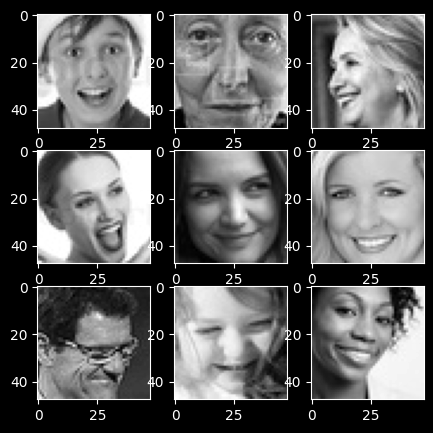

In [67]:
plot_images('validation','happy')

### Load and store features and target data

In [52]:
def load_data(train_val_folder, expression):
    X, y = [], []
    
    for dirname, _, filenames in os.walk(f'../raw_data/images/{train_val_folder}/{expression}'):
        for filename in filenames:
            X.append(plt.imread(os.path.join(dirname, filename))[:, :])
            y.append(expression) 
        
    c = list(zip(X, y))
    np.random.shuffle(c)
    X, y = zip(*c)
    print(f'Number of {expression} images inside {train_val_folder} folder : {len(X)}')
        
    return np.array(X), np.array(y)

In [85]:
X_train = np.array([])
X_val = np.array([])
y_train = np.array([])
y_val = np.array([])
X_temp_train = np.array([])
X_temp_val = np.array([])
#we don't take 'disgust' because it has less images that can unbalance the data
expressions = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
for expression in expressions:
    #load data by expression folder
    X_train, y_train = load_data("train", expression)
    X_val, y_val = load_data("validation", expression)
    
    if len(X_temp_train)>0:
        #append them in features and target variables
        X_train = np.append(X_temp_train, X_train, axis=0)
        y_train = np.append(y_temp_train, y_train)
    if len(X_temp_val)>0:
        X_val = np.append(X_temp_val, X_val, axis=0)
        y_val = np.append(y_temp_val, y_val)
    
    X_temp_train = X_train
    y_temp_train = y_train
    X_temp_val = X_val
    y_temp_val = y_val

Number of angry images inside train folder : 3993
Number of angry images inside validation folder : 960
Number of fear images inside train folder : 4103
Number of fear images inside validation folder : 1018
Number of happy images inside train folder : 7164
Number of happy images inside validation folder : 1825
Number of neutral images inside train folder : 4982
Number of neutral images inside validation folder : 1216
Number of sad images inside train folder : 4938
Number of sad images inside validation folder : 1139
Number of surprise images inside train folder : 3205
Number of surprise images inside validation folder : 797


In [86]:
print(f'X_train shape : {X_train.shape}')
print(f'y_train shape : {y_train.shape}')
print(f'X_val shape : {X_val.shape}')
print(f'y_val shape : {y_val.shape}')

X_train shape : (28385, 48, 48)
y_train shape : (28385,)
X_val shape : (6955, 48, 48)
y_val shape : (6955,)


### Standardize image data

In [87]:
X_train = X_train/255.
X_val = X_val/255.

Add grayscale channel to train and validation set

In [88]:
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

In [89]:
print(f'New X_train shape : {X_train.shape}')
print(f'New X_val shape : {X_val.shape}')

New X_train shape : (28385, 48, 48, 1)
New X_val shape : (6955, 48, 48, 1)


### Encode target

In [110]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(pd.DataFrame(y_train))
y_train_encoded = encoder.transform(pd.DataFrame(y_train)).toarray()
y_val_encoded = encoder.transform(pd.DataFrame(y_val)).toarray()

In [116]:
print(f'New y_train shape : {y_train_encoded.shape}')
print(f'New y_val shape : {y_val_encoded.shape}')

New y_train shape : (28385, 6)
New y_val shape : (6955, 6)


### CNN model

In [120]:
no_of_classes = 6

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))



opt = Adam(learning_rate = 0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_7 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 128)      

In [121]:
es_callback = EarlyStopping(patience=4,restore_best_weights=False)
history = model.fit(X_train, y_train_encoded, batch_size=64, 
                    epochs=20, validation_data=(X_val, y_val_encoded), callbacks=[es_callback])

2022-11-02 20:51:40.159670: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 261596160 exceeds 10% of free system memory.


Epoch 1/20


2022-11-02 20:52:04.050515: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 37748736 exceeds 10% of free system memory.
2022-11-02 20:52:06.024034: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 37748736 exceeds 10% of free system memory.
2022-11-02 20:52:06.340552: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18874368 exceeds 10% of free system memory.
2022-11-02 20:52:06.753726: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18874368 exceeds 10% of free system memory.


 39/444 [=>............................] - ETA: 53:58 - loss: 2.1532 - accuracy: 0.1823

KeyboardInterrupt: 

In [ ]:
plt.plot(history['accuracy'])